# Pneumonia classification from Chest X-Ray data with EfficientNet

## Hardware Check (GPU vs CPU)

In [1]:
import tensorflow as tf

# Check if a GPU is available
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("TensorFlow is using the GPU:")
    for gpu in gpus:
        print(f"- {gpu}")
else:
    print("TensorFlow is using the CPU.")

TensorFlow is using the GPU:
- PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [2]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


## Library and Data Import

In [3]:
import kagglehub
import os
import random as rand
import shutil
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import save_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence
import tensorflow_hub as hub # tensorflow_hub is giving some dependency clashes when running in Conda
import numpy as np
from numpy import sqrt, random, round
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

c:\Users\caomi\anaconda3\envs\tf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\caomi\.cache\kagglehub\datasets\paultimothymooney\chest-xray-pneumonia\versions\2


After downloading the Kaggle dataset, I moved the file to within the project repo for easier data handling

In [4]:
# base_path = "D:\\Minh Nguyen\\TME_6015\\Assignment_2\\chest_xray"   # Home PC
# base_path = "C:\\Minh Nguyen\\TME_6015\\Assignment_2\\chest_xray"   # Laptop
# base_path = "C:\mnguyen\TME_6015\Assignment_2\chest_xray"           # Work PC

# Find path to the dataset folder
current_dir = os.getcwd()
base_path = os.path.join(current_dir,'chest_xray')

train_dir = os.path.join(base_path,'train')
val_dir = os.path.join(base_path,'val')
test_dir = os.path.join(base_path,'test')


## Ensure train-validation split

In [5]:
def count_data(train_dir, val_dir, test_dir):
    num_data_ = {}
    for dir_ in [train_dir, val_dir, test_dir]:
        for category_ in ["PNEUMONIA","NORMAL"]:
            key_ = os.path.basename(dir_)+'_'+category_
            value_ = len(os.listdir(os.path.join(dir_, category_)))
            num_data_[key_] = value_
    return num_data_

num_data = count_data(train_dir, val_dir, test_dir)

print("The number of data in the corresponding categories:")
print(num_data)

The number of data in the corresponding categories:
{'train_PNEUMONIA': 3494, 'train_NORMAL': 1214, 'val_PNEUMONIA': 389, 'val_NORMAL': 135, 'test_PNEUMONIA': 390, 'test_NORMAL': 234}


It seem that the ratio of training samples to testing samples is acceptable. However, given that there are only 8 validation sample for each category, I will ensure that the train test split is 

In [6]:
def adjust_train_val_split(train_dir, val_dir, desired_split=0.8, seed=42):
    """
    Adjust the train-validation split for the dataset.
    
    Parameters:
    - train_dir (str): Path to the training directory.
    - val_dir (str): Path to the validation directory.
    - desired_split (float): Desired ratio of train to total data (e.g., 0.8 for 80% train, 20% validation).
    - seed (int): Random seed for reproducibility.
    """
    # Set seed for reproducibility
    random.seed(seed)
    
    for category in ["PNEUMONIA","NORMAL"]:
        train_category_dir = os.path.join(train_dir, category)
        val_category_dir = os.path.join(val_dir, category)
        
        # Ensure the validation category directory exists
        os.makedirs(val_category_dir, exist_ok=True)
        
        # Get lists of images in train and val directories for this category
        train_images = os.listdir(train_category_dir)
        val_images = os.listdir(val_category_dir)
        
        # Total number of images for this category
        total_images = len(train_images) + len(val_images)
        
        # Calculate desired number of train and validation images
        desired_train_count = int(total_images * desired_split)
        desired_val_count = total_images - desired_train_count
        
        # Adjust train set if necessary
        if len(train_images) > desired_train_count:
            # Move excess images from train to val
            move_count = len(train_images) - desired_train_count
            images_to_move = rand.sample(train_images, move_count)
            for img in images_to_move:
                image_to_move_path = os.path.join(train_category_dir, img)
                shutil.move(image_to_move_path, val_category_dir)
        
        elif len(train_images) < desired_train_count:
            # Move images from val to train to increase training set
            move_count = desired_train_count - len(train_images)
            images_to_move = rand.sample(val_images, move_count)
            for img in images_to_move:
                image_to_move_path = os.path.join(val_category_dir, img)
                shutil.move(image_to_move_path, train_category_dir)
        
        print(f"{category}: Adjusted to {desired_train_count} train and {desired_val_count} val images.")


DESIRED_SPLIT = 0.9
adjust_train_val_split(train_dir, val_dir, desired_split=DESIRED_SPLIT)

PNEUMONIA: Adjusted to 3494 train and 389 val images.
NORMAL: Adjusted to 1214 train and 135 val images.


Here I am counting the number of samples of both types in the train, validation, and test sets. The purpose of this will be clear in the next section, where I extract the data into arrays

In [7]:
num_data_category = {}
for dir_ in [train_dir, val_dir, test_dir]:
    key_ = os.path.basename(dir_)
    value_ = 0
    for category_ in ["PNEUMONIA","NORMAL"]:
        value_ += len(os.listdir(os.path.join(dir_,category_)))
    num_data_category[key_] = value_

num_data_category

{'train': 4708, 'val': 524, 'test': 624}

## Extract Data

In the following code block, I will extract the images from the directories of the train, validation, and test set for model training in terms of a generator

### Data from directory (disk) => np arrays (memory)

At first, I noticed that model training was fairly slow and the GPU was not fully utilized. The training time was ~1 min/epoch even when the model only has 12,000+ trainable parameters. The model training performance was worse compared to training the pet breed classification model: <10s/epoch with 210,000+ trainable parameters and 2,944 training images. From my research, the flow_from_directory() channels images from the directory (disk or ROM) batch by batch for the model to train. This means that the I/O and data transfer speed act as a bottleneck in the training process and the images are not loaded on the GPU memory fast enough to fully utilize it.

From further research, a potential solution was to increase the batch size so that more images are loaded onto the GPU at a time during training. However, even when increasing the BATCH_SIZE value form 32 to 128 and 256, training time only improve slightly.

Another solution was to load the entire directory (train/validation/test) into numpy arrays at the start. These numpy array are now stored on memory (RAM) can then be converted to generator objects such that they generate batches of data for training on the GPU. The difference between this batch processing approach and the previous method is the location of the data (disk vs memory). As a result of this, when the model is trained and evaluated given the corresponsding generator, training time reduced to less than 10 seconds per epoch. At the expense of time and memory required to load the entire dataset from disk to memory (~50 seconds for train set, ~5 seconds each for validation and test set), I was able to achieve much faster training to enable more parameter tuning to improve model performance

In [8]:
IMAGE_SIZE = (224,224)              # input image dimensions for an EfficientNetB0 model

BATCH_SIZE_TRAIN = num_data_category['train']
BATCH_SIZE_VAL = num_data_category['val']
BATCH_SIZE_TEST = num_data_category['test']

train_gen_from_dir = ImageDataGenerator(
    rescale=1/255.0,
    rotation_range=20,
    # width_shift_range=0.1,
    # height_shift_range=0.1,
    # shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

train_set_raw = train_gen_from_dir.flow_from_directory(
    train_dir, 
    target_size=IMAGE_SIZE, 
    batch_size=BATCH_SIZE_TRAIN, 
    class_mode="binary"
)

train_image_array, train_label_array = next(train_set_raw)

Found 4708 images belonging to 2 classes.


In [9]:
val_gen_from_dir = ImageDataGenerator(rescale=1/255)
val_set_raw = val_gen_from_dir.flow_from_directory(
    val_dir, 
    target_size=IMAGE_SIZE, 
    batch_size=BATCH_SIZE_VAL, 
    class_mode="binary"
)

valid_image_array, valid_label_array = next(val_set_raw)

Found 524 images belonging to 2 classes.


In [10]:
test_gen_from_dir = ImageDataGenerator(rescale=1/255)
test_set_raw = test_gen_from_dir.flow_from_directory(
    test_dir, 
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE_TEST, 
    class_mode="binary"
)

test_image_array, test_label_array = next(test_set_raw)

Found 624 images belonging to 2 classes.


### np array => Data Generator conversion

This is done to conserve the RAM usage on the GPU by generating the data sample from the numpy array in batches according to BATCH_SIZE

In [11]:
class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y
    
BATCH_SIZE = 32

# These generator objects will generate 32 data at a time from the specified nparray's
train_gen = DataGenerator(train_image_array,train_label_array,BATCH_SIZE)
val_gen = DataGenerator(valid_image_array,valid_label_array,BATCH_SIZE)
test_gen = DataGenerator(test_image_array,test_label_array,BATCH_SIZE)

### Confirm the image size

In [12]:
# Print the shape of the images and labels in this batch
print("Image batch shape:", train_image_array.shape)
print("Label batch shape:", train_label_array.shape)

_, height, width, channel = train_image_array.shape
IMAGE_SHAPE = (height,width,channel)

Image batch shape: (4708, 224, 224, 3)
Label batch shape: (4708,)


## EfficientNetB0-based model

### Full Model Construction

In [13]:
model_url = r"https://www.kaggle.com/models/google/efficientnet-v2/TensorFlow2/imagenet1k-b0-classification/2"

def create_model(model_url, num_classes=1):
  # Base model
  base_model = hub.KerasLayer(model_url,
                              trainable=False, 
                              name='feature_extraction_layer',
                              input_shape=IMAGE_SHAPE
  ) 
  
  # 
  model = tf.keras.Sequential([
    layers.Input(shape=IMAGE_SHAPE),
    base_model,
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(10, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, 
                 activation='sigmoid', 
                 name='output_layer')
  ])

  return model

model = create_model(model_url)

initial_weights = model.get_weights()

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1000)             7200312   
 erasLayer)                                                      
                                                                 
 batch_normalization (BatchN  (None, 1000)             4000      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 1000)              0         
                                                                 
 dense (Dense)               (None, 10)                10010     
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 output_layer (Dense)        (None, 1)                 1

### Model Training

In [26]:
LR = 0.0001

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR), 
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=["accuracy","AUC"])
loss0, acc0, auc0 = model.evaluate(test_gen)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(acc0))

20/20 [==============================] - 2s 32ms/step - loss: 0.3650 - accuracy: 0.9135 - auc: 0.9580
initial loss: 0.37
initial accuracy: 0.91


In [27]:
# Train the model with the base layers frozen
initial_epochs = 20
model.set_weights(initial_weights)

history = model.fit(train_gen,
                    validation_data=val_gen, 
                    epochs=initial_epochs)


Epoch 1/20
148/148 [==============================] - 7s 38ms/step - loss: 0.5799 - accuracy: 0.7746 - auc: 0.7384 - val_loss: 0.3596 - val_accuracy: 0.8569 - val_auc: 0.9257
Epoch 2/20
148/148 [==============================] - 5s 37ms/step - loss: 0.3854 - accuracy: 0.8356 - auc: 0.8765 - val_loss: 0.3309 - val_accuracy: 0.8626 - val_auc: 0.9533
Epoch 3/20
148/148 [==============================] - 5s 37ms/step - loss: 0.3463 - accuracy: 0.8458 - auc: 0.8975 - val_loss: 0.3158 - val_accuracy: 0.8531 - val_auc: 0.9656
Epoch 4/20
148/148 [==============================] - 6s 38ms/step - loss: 0.3199 - accuracy: 0.8645 - auc: 0.9150 - val_loss: 0.3056 - val_accuracy: 0.8569 - val_auc: 0.9708
Epoch 5/20
148/148 [==============================] - 6s 39ms/step - loss: 0.3065 - accuracy: 0.8698 - auc: 0.9226 - val_loss: 0.2904 - val_accuracy: 0.8607 - val_auc: 0.9759
Epoch 6/20
148/148 [==============================] - 6s 38ms/step - loss: 0.2914 - accuracy: 0.8813 - auc: 0.9306 - val_loss

In [16]:
def plot_performance(history, learning_rate=None, batch_size=None, finetune_epochs=None):
  plt.figure(figsize=(10,5))

  # history_data = history.history

  # Determine whether history is keras history or a dictionary to appropriately extract the history data
  if isinstance(history, tf.keras.callbacks.History):
    history_data = history.history        # Extract the history dictionary
  else:
    history_data = history                # Assume it's already a dictionary

  # Accuracy of model training and validation vs training epoch
  plt.subplot(1,2,1)
  ylim_acc = [min(min(history_data['accuracy']),min(history_data['val_accuracy'])), 1]
  plt.plot(history_data['accuracy'], label = 'Training accuracy')
  plt.plot(history_data['val_accuracy'], label = 'Validation accuracy')
  plt.ylim(ylim_acc)
  if finetune_epochs:
    plt.plot([finetune_epochs-1, finetune_epochs-1],plt.ylim(), label = 'Fine tuning')
  else:
    pass

  if learning_rate and batch_size:
    plt.title(f'Model accuracy \n lr = {learning_rate}, batch size = {batch_size}')
  else: plt.title('Model accuracy')

  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(loc='lower right')
  plt.grid(which='major', color='black', linestyle='-', linewidth=0.25)
  plt.grid(which='minor', color='gray', linestyle=':', linewidth=0.5)
  plt.minorticks_on()


  # Loss during model training and validation
  plt.subplot(1,2,2)
  ylim_loss = [0, max(max(history_data['loss']),max(history_data['val_loss']))]
  # print(len(history_data['loss']))
  plt.plot(history_data['loss'], label = 'Training loss')
  plt.plot(history_data['val_loss'], label = 'Validation loss')
  plt.ylim(ylim_loss)
  if finetune_epochs:
    plt.plot([finetune_epochs-1, finetune_epochs-1],plt.ylim(), label = 'Fine tuning')
  else:
    pass

  if learning_rate and batch_size:
    plt.title(f'Model loss \n lr = {learning_rate}, batch size = {batch_size}')
  else: plt.title('Model loss')

  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(loc='lower right')
  plt.grid(which='major', color='black', linestyle='-', linewidth=0.25)
  plt.grid(which='minor', color='gray', linestyle=':', linewidth=0.5)
  plt.minorticks_on()
  plt.show()

  print(f"The model has a training accuracy of {history_data['accuracy'][-1]*100:.2f}%\n"
      f"The model has a validation accuracy of {history_data['val_accuracy'][-1]*100:.2f}%")
  return

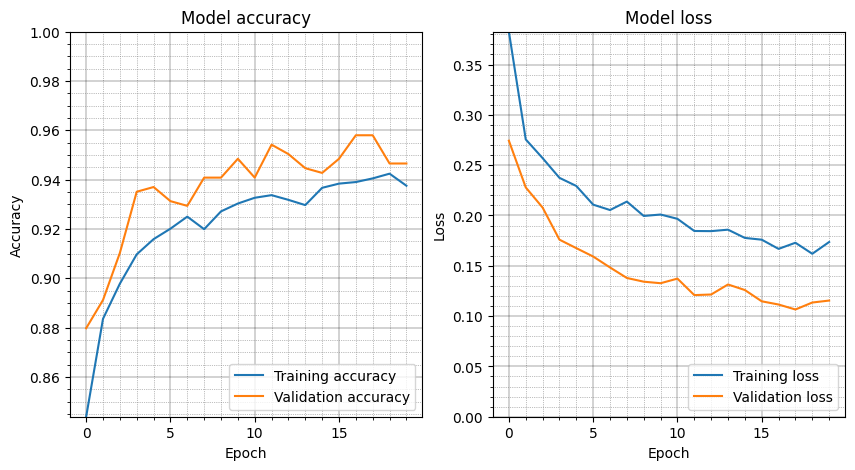

The model has a training accuracy of 93.76%
The model has a validation accuracy of 94.66%


In [17]:
plot_performance(history)

### Model Evaluation

In [18]:
test_loss, test_acc, test_auc = model.evaluate(test_gen,batch_size=BATCH_SIZE)
print(f"Test accuracy: {test_acc*100:.2f}%\n"
      f"Test loss: {test_loss:.4f}\n"
      f"Test AUC score: {test_auc:.4f}")

20/20 [==============================] - 1s 33ms/step - loss: 0.3650 - accuracy: 0.9135 - auc: 0.9580
Test accuracy: 91.35%
Test loss: 0.3650
Test AUC score: 0.9580


In [20]:
prediction_array = (model.predict(test_image_array,batch_size=BATCH_SIZE)>0.5).astype(int)

20/20 [==============================] - 1s 32ms/step


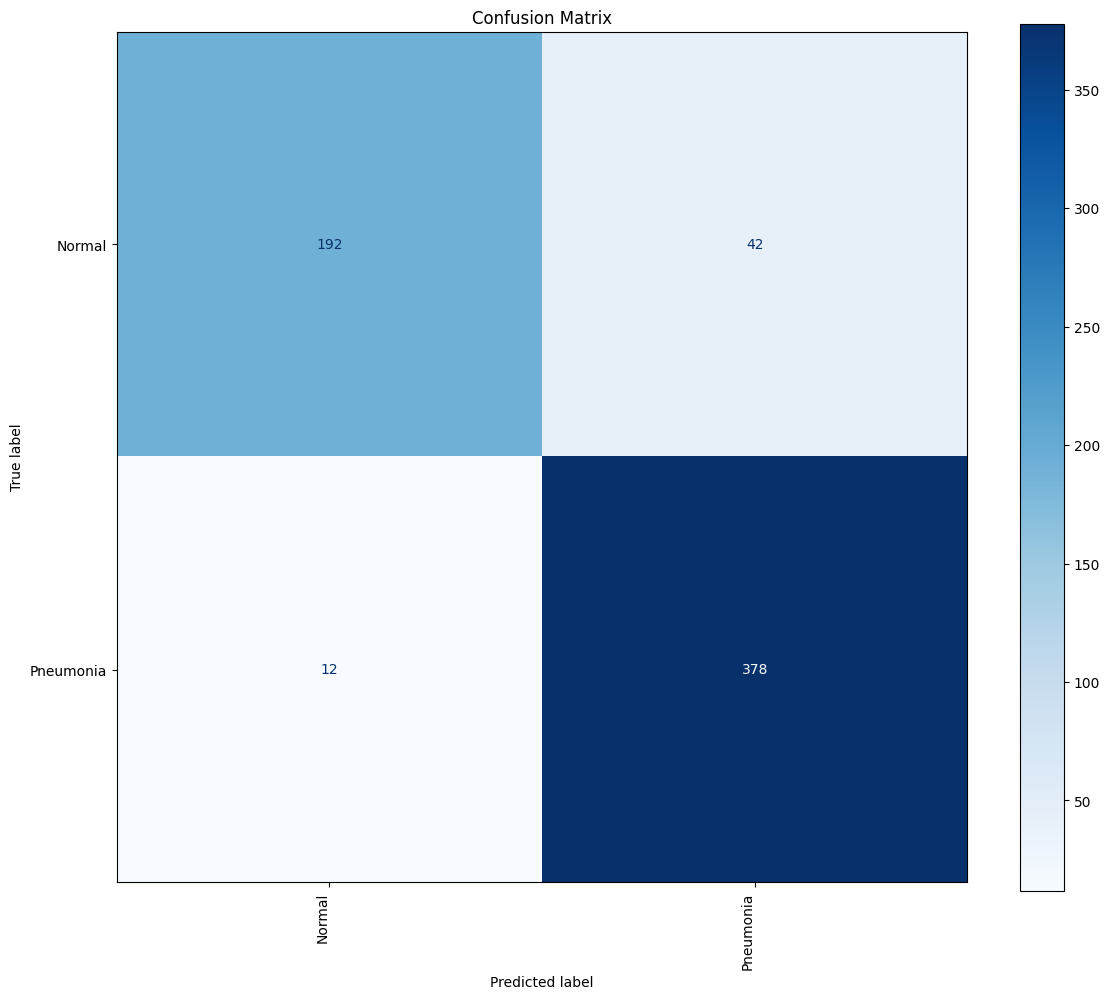

In [23]:
cm = confusion_matrix(test_label_array, prediction_array)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["Normal", "Pneumonia"])
disp.plot(cmap=plt.cm.Blues)  # You can change the color map as desired
fig = disp.ax_.get_figure() 
fig.set_figwidth(12); fig.set_figheight(10) 
plt.title("Confusion Matrix")
plt.xticks(rotation=90, ha='right')  # Rotate x labels for better readability
plt.yticks(rotation=0)  # Keep y labels horizontal
plt.tight_layout()  # Adjust layout to make room for rotated labels
plt.show()

### Model Prediction and Visualization

1/1 [==============================] - 0s 27ms/step


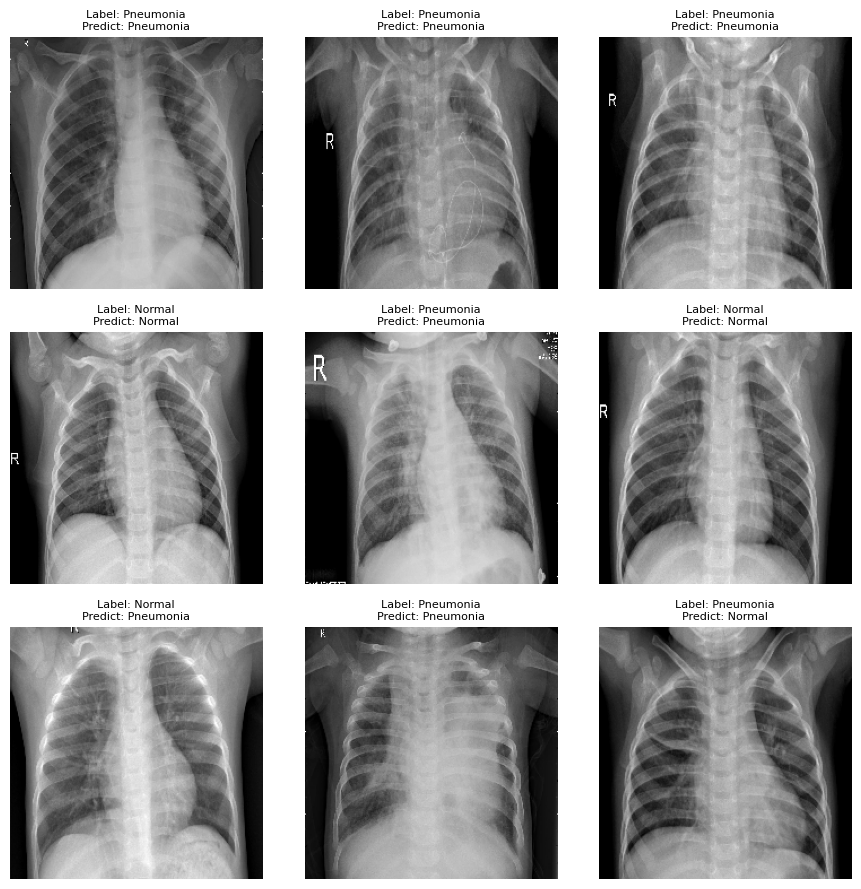

In [25]:
# Sample random images and their indices
random_test_batch = next(test_set_raw)                  # take a random batch from the test data generator
test_image_array, test_label_array = random_test_batch

num_samples = 9                                         # number of samples to be display
num_rows = int(round(sqrt(num_samples))); 
num_cols = int(num_samples/num_rows)                    # number of rows and columns for the subplot
rand = random.randint(BATCH_SIZE,size = (num_samples))    # random index for choosing the samples in the dataset

image_test_rand_array = test_image_array[rand]
label_test_rand_array = test_label_array[rand]
prediction_rand_array = (model.predict(image_test_rand_array) > 0.5).astype(int)

plt.figure(figsize=(num_rows*3,num_cols*3))
# fig, axes1 = plt.subplots(num_rows,num_cols,figsize=(num_rows*2,num_cols2))

for i in range(num_rows):
    for j in range(num_cols):
        index = i * num_cols + j
        plt.subplot(num_rows,num_cols,index+1)
        image = image_test_rand_array[index]  # Extract the image
        label = label_test_rand_array[index]  # Extract the label
        label_word = "Pneumonia" if label==1 else "Normal"
        prediction = "Pneumonia" if prediction_rand_array[index][0]==1 else "Normal"

        # Original pictures (no augmentation layer applied)
        plt.axis("off")
        # Display the image
        plt.imshow(image)
        plt.title(f"Label: {label_word}\n"
                  f"Predict: {prediction}",
                  fontsize = 8) 

plt.tight_layout()